# Importaciones

In [ ]:
# DataFrames
import pandas as pd
# Rutas
import os
from pathlib import Path
# Operaciones y métricas
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
# Modelo
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
import pytorch_forecasting
from lightning.pytorch import Trainer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import MAE, SMAPE, QuantileLoss
import torch
import pickle
from pytorch_forecasting.data.encoders import GroupNormalizer
from torch.nn.modules.container import ModuleList
from pandas._libs.internals import _unpickle_block
import numpy.core.multiarray
# Lista ampliada de clases para safe_globals
safe_globals = [
    pd.DataFrame,
    pd.core.series.Series,
    pd.core.indexes.base.Index,
    pd.core.indexes.datetimes.DatetimeIndex,
    pd.core.internals.managers.BlockManager,
    pd.core.internals.blocks.NumericBlock,
    pd.core.internals.blocks.ObjectBlock,
    TimeSeriesDataSet,
    GroupNormalizer,
    QuantileLoss,  
    ModuleList,    
    _unpickle_block,
    numpy.core.multiarray._reconstruct,
    np.int32,     
    dict, list, tuple, str, int, float
]

Para la preparación del DataSet, en el caso de TFT tenemos una serie de requisitos más específicos que en modelos como SARIMAX o XGBoost:

- Debemos dar un índice numérico

- Un identificador de la serie temporal

- Introducimos las varaibles exógenas en las columnas

In [33]:
notebook_path = Path().resolve()
data_dir = notebook_path.parent/'archivos'/'archivos_formateados'

ruta_luz = data_dir/'precio-luz-conformato.csv'
ruta_eolica = data_dir/'generacion-eolica-conformato.csv'
ruta_solar = data_dir/'generacion-solar-conformato.csv'
ruta_demanda = data_dir/'demanda-real-conformato.csv'

precio_luz = pd.read_csv(ruta_luz)
generacion_eolica = pd.read_csv(ruta_eolica)
generacion_solar = pd.read_csv(ruta_solar)
demanda_real = pd.read_csv(ruta_demanda)

fecha_fin = pd.to_datetime('2025-06-30T23:00:00Z')

# Datos

In [19]:
def process_time_series_df(df, value_col, end_date):
    df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
    df = df.set_index('datetime').asfreq('h')
    df[value_col] = pd.to_numeric(df[value_col], errors='coerce')
    return df.loc[:end_date].dropna(subset=[value_col])

precio_luz = process_time_series_df(precio_luz, 'precio', fecha_fin)
generacion_eolica = process_time_series_df(generacion_eolica, 'generacion', fecha_fin)
generacion_solar = process_time_series_df(generacion_solar, 'generacion', fecha_fin)
demanda_real = process_time_series_df(demanda_real, 'demanda', fecha_fin)

df = precio_luz.copy()
df['generacion_eolica'] = generacion_eolica['generacion'].shift(24)
df['generacion_solar'] = generacion_solar['generacion'].shift(24)
df['demanda_real'] = demanda_real['demanda'].shift(24)
df['rolling_mean_24'] = df['precio'].rolling(24).mean()
df['rolling_std_24'] = df['precio'].rolling(24).std()
df['rolling_mean_24_eolica'] = df['generacion_eolica'].rolling(24).mean()
df['rolling_std_24_eolica'] = df['generacion_eolica'].rolling(24).std()
df['rolling_mean_24_solar'] = df['generacion_solar'].rolling(24).mean()
df['rolling_std_24_solar'] = df['generacion_solar'].rolling(24).std()
df['rolling_mean_24_demanda'] = df['demanda_real'].rolling(24).mean()
df['rolling_std_24_demanda'] = df['demanda_real'].rolling(24).std()

columnas_exogenas = [
    'generacion_eolica',
    'generacion_solar', 
    'demanda_real',
    'hora', 
    'dia_semana',
    'mes',
    'rolling_mean_24', 
    'rolling_std_24',
    'rolling_mean_24_eolica', 
    'rolling_std_24_eolica',
    'rolling_mean_24_solar', 
    'rolling_std_24_solar',
    'rolling_mean_24_demanda', 
    'rolling_std_24_demanda',
]

for col in columnas_exogenas:
    if col in df.columns:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)
df = df.ffill().bfill()
df = df.dropna()
df = df.reset_index()

In [20]:
df['time_idx'] = (df['datetime'] - df['datetime'].min()).dt.total_seconds() // 3600
df['time_idx'] = df['time_idx'].astype(int)
df['group_id'] = 'Serie-precio-Luz'

df['hora'] = df['datetime'].dt.hour
df['dia_semana'] = df['datetime'].dt.dayofweek
df['dia_mes'] = df['datetime'].dt.day
df['mes'] = df['datetime'].dt.month

print("<------------ Comprobamos el formato del DataSet original ------------>")
display(df.head(5))

<------------ Comprobamos el formato del DataSet original ------------>


,datetime,precio,update_date,generacion_eolica,generacion_solar,demanda_real,rolling_mean_24,rolling_std_24,rolling_mean_24_eolica,rolling_std_24_eolica,rolling_mean_24_solar,rolling_std_24_solar,rolling_mean_24_demanda,rolling_std_24_demanda,time_idx,group_id,hora,dia_semana,dia_mes,mes
0,2022-12-31 23:00:00+00:00,0.0,2025-07-25,5993.069,19.75,20006.333333,6.697083,12.551486,6705.658375,2415.033516,1278.979167,1971.31611,19618.704861,2661.365056,0,Serie-precio-Luz,23,5,31,12
1,2023-01-01 00:00:00+00:00,0.0,2025-07-25,5993.069,19.75,20006.333333,6.697083,12.551486,6705.658375,2415.033516,1278.979167,1971.31611,19618.704861,2661.365056,1,Serie-precio-Luz,0,6,1,1
2,2023-01-01 01:00:00+00:00,0.0,2025-07-25,5993.069,19.75,20006.333333,6.697083,12.551486,6705.658375,2415.033516,1278.979167,1971.31611,19618.704861,2661.365056,2,Serie-precio-Luz,1,6,1,1
3,2023-01-01 02:00:00+00:00,0.0,2025-07-25,5993.069,19.75,20006.333333,6.697083,12.551486,6705.658375,2415.033516,1278.979167,1971.31611,19618.704861,2661.365056,3,Serie-precio-Luz,2,6,1,1
4,2023-01-01 03:00:00+00:00,0.0,2025-07-25,5993.069,19.75,20006.333333,6.697083,12.551486,6705.658375,2415.033516,1278.979167,1971.31611,19618.704861,2661.365056,4,Serie-precio-Luz,3,6,1,1


In [21]:
# Parámetros del modelo
max_prediction_length = 24 * 7 * 4 # Predecir el próximo mes
max_encoder_length = 24 * 7 * 4 * 3  # Usamos los 3 meses anteriores

# Fijamos el inicio de la predicción final
fecha_inicio_prediccion = pd.to_datetime("2025-06-01T00:00:00+00:00")
df_historico = df[df['datetime'] < fecha_inicio_prediccion].copy()

# El conjunto de validación serán los últimos `max_prediction_length` puntos del histórico.
training_cutoff = df_historico["time_idx"].max() - max_prediction_length
df_train = df_historico[df_historico["time_idx"] <= training_cutoff].copy()

print(f"Última fecha en train: {df_train['datetime'].max()}")
print(f"Primera fecha en test: {df_historico[df_historico['time_idx'] > training_cutoff]['datetime'].min()}")

Última fecha en train: 2025-05-03 23:00:00+00:00
Primera fecha en test: 2025-05-04 00:00:00+00:00


# Análisis exploratorio

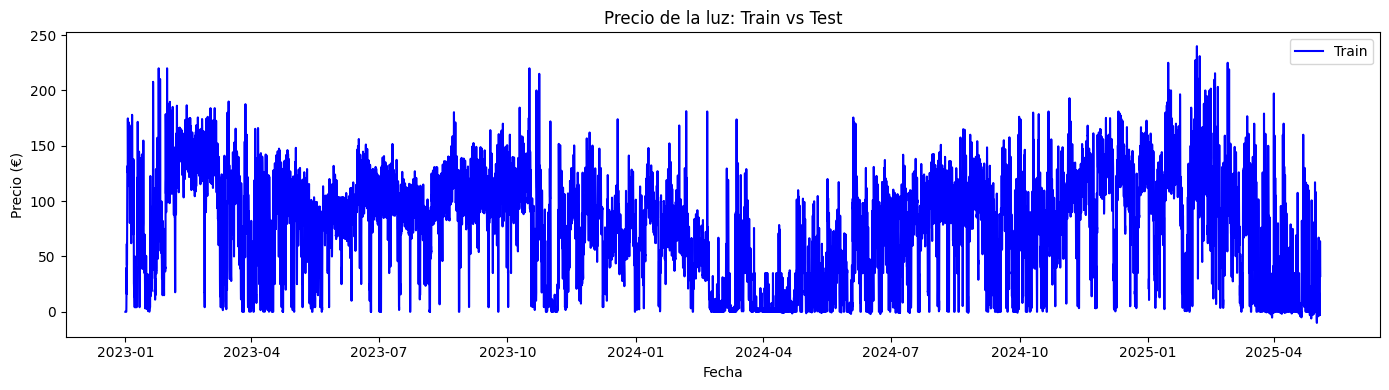

In [6]:
plt.figure(figsize=(14, 4))
plt.plot(df_train['datetime'], df_train['precio'], label='Train', color='blue')
plt.title('Precio de la luz: Train vs Test')
plt.xlabel('Fecha')
plt.ylabel('Precio (€)')
plt.legend()
plt.tight_layout()
plt.show()

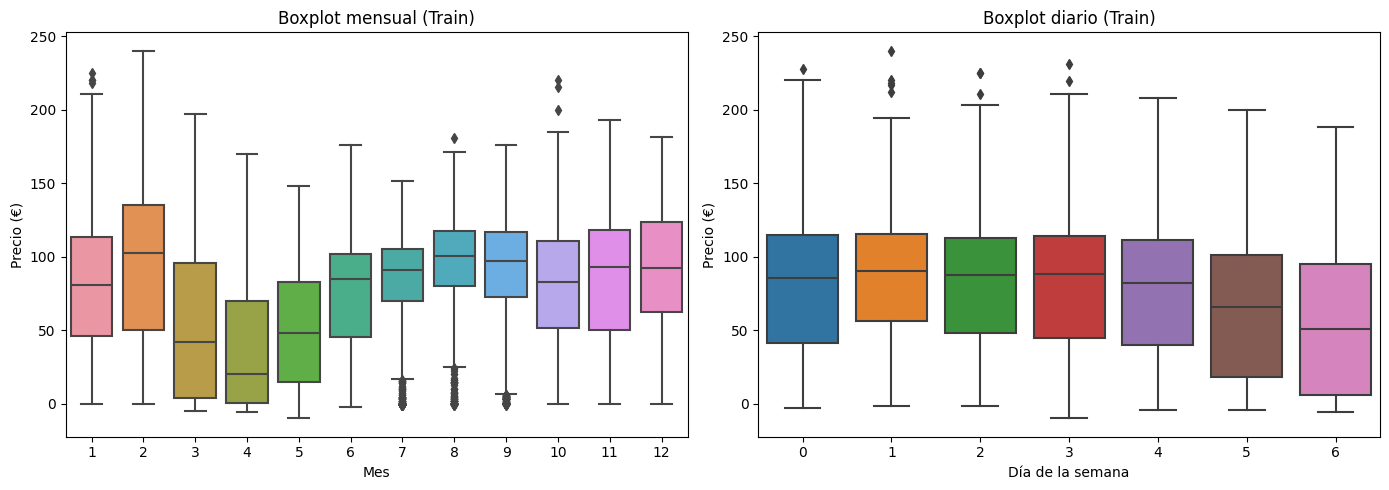

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(x=df_train['mes'], y=df_train['precio'], ax=axes[0])
axes[0].set_title('Boxplot mensual (Train)')
axes[0].set_xlabel('Mes')
axes[0].set_ylabel('Precio (€)')

sns.boxplot(x=df_train['dia_semana'], y=df_train['precio'], ax=axes[1])
axes[1].set_title('Boxplot diario (Train)')
axes[1].set_xlabel('Día de la semana')
axes[1].set_ylabel('Precio (€)')
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

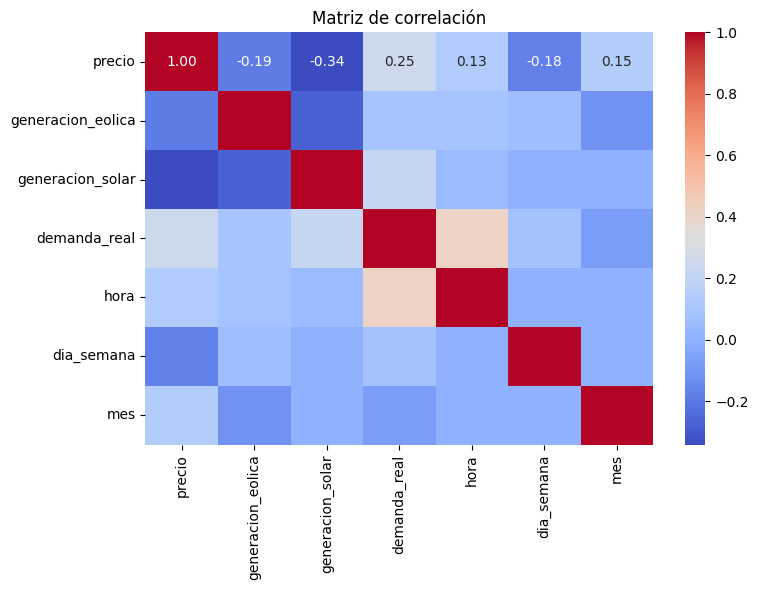

In [8]:
plt.figure(figsize=(8, 6))
corr = df_train[['precio', 'generacion_eolica', 'generacion_solar', 'demanda_real', 'hora', 'dia_semana', 'mes']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')
plt.tight_layout()
plt.show

# Modelo TFT

## Creamos el TimeSeriesDataset

Preparamos el cojunto de datos

In [9]:
# Creamos el TimeSeriesDataset para el entrenamiento
training_dataset = TimeSeriesDataSet(
    df_train,
    time_idx="time_idx",
    target="precio",
    group_ids=["group_id"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["hora", "dia_semana", "dia_mes", "mes"],
    time_varying_unknown_reals=["precio", "generacion_eolica", "generacion_solar", "demanda_real", "rolling_mean_24", 
    "rolling_std_24",  "rolling_mean_24_eolica",   "rolling_std_24_eolica",  "rolling_mean_24_solar",   "rolling_std_24_solar",  "rolling_mean_24_demanda",   "rolling_std_24_demanda",],
    target_normalizer = GroupNormalizer(groups=["group_id"]),
    lags={"precio": [24, 24*7]},
    add_relative_time_idx=True,
    allow_missing_timesteps=False
)

# Creamos el dataset de validación a partir del de entrenamiento y los datos históricos completos
validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset, df_historico, predict=True, stop_randomization=True
)

# Creamos los dataloaders para PyTorch
batch_size = 16
train_dataloader = training_dataset.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation_dataset.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)

Creamos una baseline para ver como va a ir nuestro modelo. Esta calcula el MAE a partir de predecir a partir del histórico para ver como va a evolucionar.

In [10]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions_naive = []
for x, y in iter(val_dataloader):
    # Toma el último valor del encoder para cada secuencia en el batch
    last_encoder_values = x["encoder_target"][:, -1]
    # Repite este valor para toda la longitud de la predicción
    naive_preds = last_encoder_values.unsqueeze(1).repeat(1, max_prediction_length)
    baseline_predictions_naive.append(naive_preds)

baseline_predictions = torch.cat(baseline_predictions_naive)

mae_baseline = (actuals - baseline_predictions).abs().mean().item()

print(f"<------------ ERROR BASELINE ------------> ")
print(f"MAE niave: {mae_baseline:.2f}")

<------------ ERROR BASELINE ------------> 
MAE niave: 25.73


Hacemos una búsqueda de hiperparámetros (descomentar en la versión final para hcer la búsqueda completa)

In [ ]:
study = optimize_hyperparameters(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    model_path="optuna_tft", 
    n_trials=500,
    max_epochs=100,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(4, 128),
    hidden_continuous_size_range=(4, 64),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.3),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(
        accelerator="gpu",
        devices=1
    ),
    use_learning_rate_finder=False,
    verbose=True
)

with open("tft_study_results.pkl", "wb") as fout:
    pickle.dump(study, fout)

best_params = study.best_trial.params
print("<------------ MEJORES HIPERPARÁMETROS ENCONTRADOS ------------>")
print(best_params)

Eliminar cuando se haga la prediccion completa

In [12]:
best_params = {
    'gradient_clip_val': 0.1,
    'hidden_size': 32,
    'dropout': 0.2,
    'hidden_continuous_size': 16,
    'attention_head_size': 4,
    'learning_rate': 0.01
}

Creamos el modelo


In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_monitor = LearningRateMonitor()
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints_tft_CONbusqueda", # Cambiar carpeta cuando ejecutemos la búsqueda
    filename="tft-epoch{epoch:02d}-val_loss{val_loss:.2f}",
    auto_insert_metric_name=False,
    monitor="val_loss",
    mode="min",        
    save_top_k=1,      
    save_last=True     
)

trainer = Trainer(
    max_epochs=50,
    accelerator="gpu",
    devices=1,
    gradient_clip_val=0.1,
    callbacks=[lr_monitor, early_stop_callback, checkpoint_callback],
)

tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=best_params['learning_rate'],
    hidden_size=best_params['hidden_size'],
    attention_head_size=best_params['attention_head_size'],
    dropout=best_params['dropout'],
    hidden_continuous_size=best_params['hidden_continuous_size'],
    output_size=7,
    loss=QuantileLoss(),
)
print(f"Número de parámetros del modelo: {tft.size() / 1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\TFT\env_tft\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\TFT\env_tft\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is rec

Número de parámetros del modelo: 106.8k


## Entrenamos el modelo

In [13]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    # Descomentar para reanudar un entrenamiento
    # ckpt_path="checkpoints_tft/last.ckpt"
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 640   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 42.3 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 9.8 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 4.3 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\model_TFT\env_TFT\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\model_TFT\env_TFT\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


## Evaluamos el test

In [ ]:
checkpoint_dir = "checkpoints_tft_sinbusqueda"
best_model_filename = "tft-epoch03-val_loss8.05.ckpt"
best_model_path = os.path.join(checkpoint_dir, best_model_filename)
print(f"Ruta del mejor modelo: {best_model_path}")
# Descomentar si da error para ver que hay que añadir o no
try:
    # print("Intentando cargar con weights_only=True y safe_globals ampliado...")
    with torch.serialization.safe_globals(safe_globals):
        best_tft = TemporalFusionTransformer.load_from_checkpoint(
            best_model_path,
            map_location=torch.device('cpu'),
            weights_only=True
        )
except Exception as e:
    # print(f"Error con weights_only=True: {e}")
    # print("Intentando con weights_only=False como última opción...")
    try:
        best_tft = TemporalFusionTransformer.load_from_checkpoint(
            best_model_path,
            map_location=torch.device('cpu'),
            weights_only=False
        )
    except Exception as e2:
        # print(f"Error con weights_only=False: {e2}")
        # print("Intentando cargar solo el state_dict y reconstruir el modelo...")
        try:
            checkpoint = torch.load(best_model_path, map_location='cpu', weights_only=False)
            state_dict = checkpoint['state_dict']
            hyper_parameters = checkpoint['hyper_parameters']
            best_tft = TemporalFusionTransformer.from_dataset(
                training_dataset, 
                **hyper_parameters
            )
            
            best_tft.load_state_dict(state_dict)
        except Exception as e3:
            # print(f"Error al reconstruir el modelo: {e3}")
            raise Exception("No se pudo cargar el modelo. Revisa el checkpoint o el entorno.")


print("✅ Modelo cargado con éxito.")

Ruta del mejor modelo: checkpoints_tft_sinbusqueda\tft-epoch03-val_loss8.05.ckpt
Intentando cargar con weights_only=True y safe_globals ampliado...
Error con weights_only=True: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.ndarray was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy.ndarray])` or the `torch.serialization.safe_globals([numpy.ndarray])` context manager to 

c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\TFT\env_tft\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\TFT\env_tft\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [43]:
# Realizar predicciones en el conjunto de validación
raw_predictions_val = best_tft.predict(
    val_dataloader,
    mode="raw",
    return_x=True,
    return_y=True
)

# Extraemos valores reales y predichos para métricas
y_true_val = raw_predictions_val.y[0].cpu().numpy().flatten()
# Usamos el cuantil 0.5 (mediana) como la predicción principal
y_pred_val = raw_predictions_val.output.prediction[:, :, 3].cpu().numpy().flatten() 

# Calcular métricas
mae_val = mean_absolute_error(y_true_val, y_pred_val)
rmse_val = mean_squared_error(y_true_val, y_pred_val, squared=False)
r2_val = r2_score(y_true_val, y_pred_val)

print("--- Evaluación en Conjunto de Validación ---")
print(f"MAE: {mae_val:.2f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"R²: {r2_val:.2f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\TFT\env_tft\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


--- Evaluación en Conjunto de Validación ---
MAE: 13.99
RMSE: 19.72
R²: 0.42


## Graficamos en el test

Visualizando 1 ejemplos de predicción...


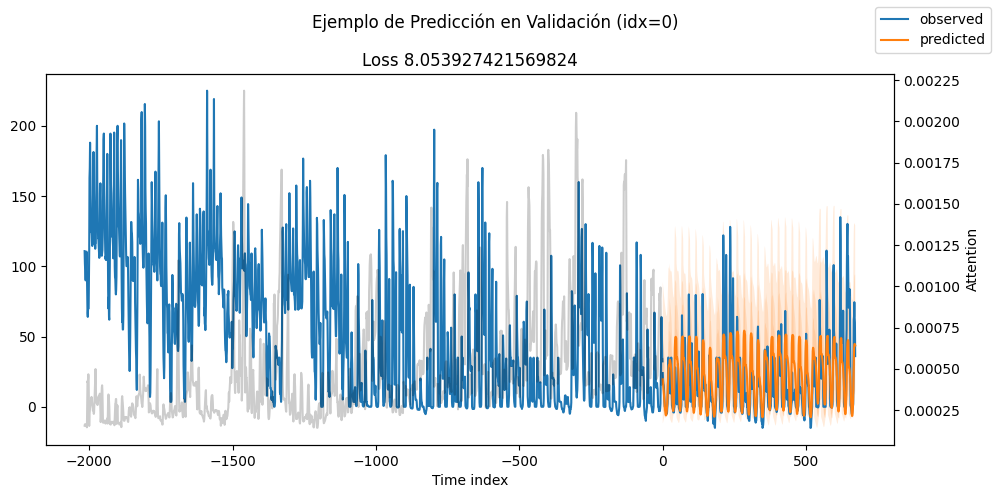

In [38]:
# Visualizamos algunos ejemplos de predicción
num_predictions = raw_predictions_val.output.prediction.shape[0]
print(f"Visualizando {min(3, num_predictions)} ejemplos de predicción...")

for i in range(min(3, num_predictions)):
    fig, ax = plt.subplots(figsize=(10, 5))
    best_tft.plot_prediction(
        x=raw_predictions_val.x,
        out=raw_predictions_val.output,
        idx=i,
        add_loss_to_title=True,
        ax=ax
    )
    plt.suptitle(f"Ejemplo de Predicción en Validación (idx={i})")
    plt.tight_layout()
    plt.show()

Interpretamos el modelo

Generando gráficos de interpretabilidad...


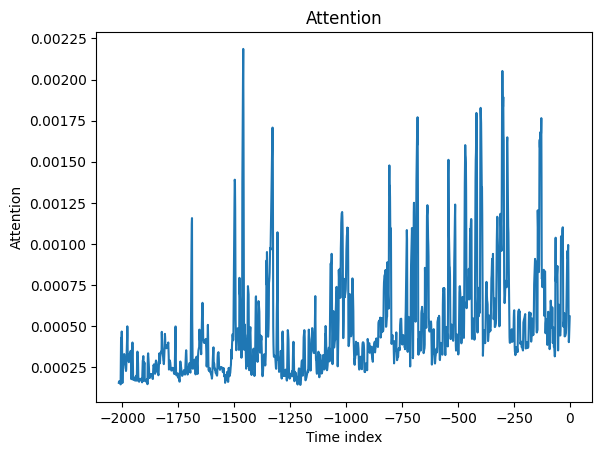

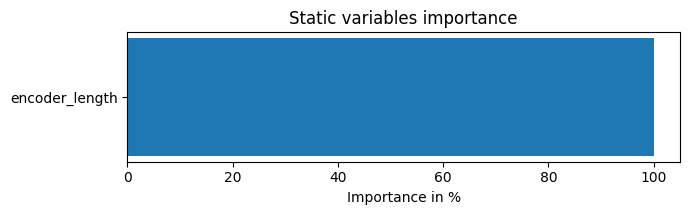

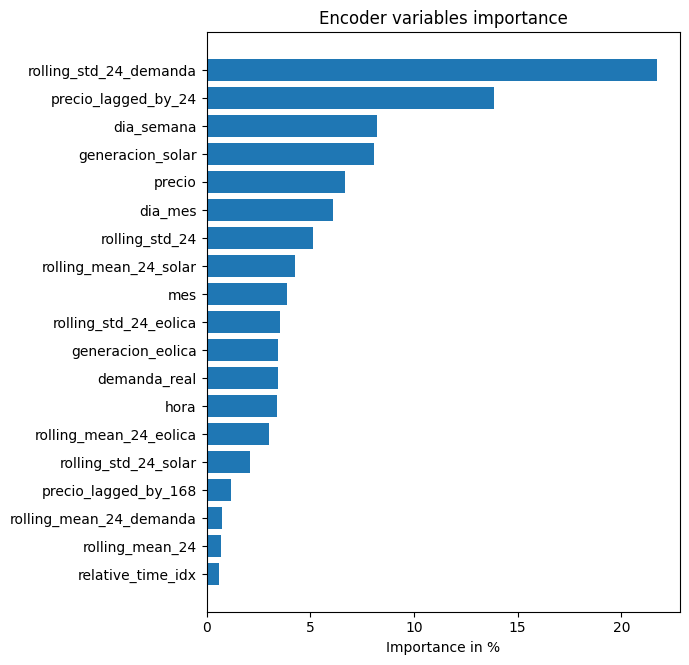

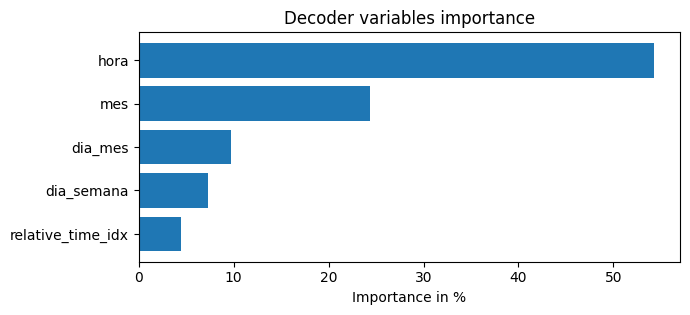

In [39]:
# Interpretabilidad del modelo
print("Generando gráficos de interpretabilidad...")
interpretation = best_tft.interpret_output(raw_predictions_val.output, reduction="sum")
best_tft.plot_interpretation(interpretation)
plt.tight_layout()
plt.show()

# Predicción

In [44]:
# Preparar datos para la predicción final
encoder_data = df_historico.tail(max_encoder_length)

# Obtener los datos reales del mes a predecir para comparar
df_test = df[df['datetime'] >= fecha_inicio_prediccion].copy()
y_true_final = df_test.head(max_prediction_length)['precio'].values

# Realizar las predicciones pasando directamente el DataFrame
print("\nRealizando la predicción final sobre el conjunto de test...")
final_predictions = best_tft.predict(encoder_data, return_index=True)

# Extraer la predicción (mediana)
y_pred_final = final_predictions.output[0][:, 3].cpu().numpy()

# Asegurarse de que ambos tienen la misma longitud para la comparación
min_len = min(len(y_pred_final), len(y_true_final))
y_pred_final_trimmed = y_pred_final[:min_len]
y_true_final_trimmed = y_true_final[:min_len]
pred_index = df_test.head(min_len)['datetime']

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Realizando la predicción final sobre el conjunto de test...


c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\TFT\env_tft\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


IndexError: too many indices for tensor of dimension 1

## Evaluamos en la prediccion (validacion)

In [ ]:
# Calcular métricas finales
mae_final = mean_absolute_error(y_true_final_trimmed, y_pred_final_trimmed)
rmse_final = mean_squared_error(y_true_final_trimmed, y_pred_final_trimmed, squared=False)
r2_final = r2_score(y_true_final_trimmed, y_pred_final_trimmed)

print(f"--- Evaluación en Conjunto de Predicción Final (Test) ---")
print(f"MAE: {mae_final:.2f}")
print(f"RMSE: {rmse_final:.2f}")
print(f"R²: {r2_final:.2f}")

## Graficamos

In [ ]:

# Visualización de las predicciones finales
print("Graficando predicción final vs. valores reales...")
plt.figure(figsize=(15, 7))
plt.plot(df_historico['datetime'], df_historico['precio'], label='Datos Históricos', color='gray', alpha=0.6)
plt.plot(pred_index, y_true_final_trimmed, label='Precio Real (Test)', color='green', marker='.')
plt.plot(pred_index, y_pred_final_trimmed, label='Precio Predicho (TFT)', color='blue', linestyle='--')
plt.title("Predicción del Precio de la Luz vs. Real (Junio 2025)")
plt.xlabel("Fecha")
plt.ylabel("Precio (€/MWh)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
# Ajustar los límites del eje x para centrarse en la predicción
plt.xlim([df_historico['datetime'].max() - pd.Timedelta(days=15), pred_index.max() + pd.Timedelta(days=1)])
plt.tight_layout()
plt.show()